In [11]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [12]:
with open('processed_corpus.json', 'r', encoding='utf-8') as f:
  corpus = json.load(f)

In [13]:
len(corpus)

100000

In [14]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [15]:
sample_text = corpus[4]

In [16]:
' '.join(sample_text)

'везде написать вклад принимать очередь это'

# Реализуйте разделение предложения на примеры методом CBOW

In [17]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    for index, token in enumerate(tokens):
        if (index - 1) < window: 
            front_context = [pad_token for i in range(abs(index - window))]
        else: 
            front_context = []
        while len(front_context) < window:
            front_context.append(tokens[index - window + len(front_context)])
        if (len(tokens) - 1 - index) < window:
            back_context = [pad_token for j in range(window - (len(tokens) - 1 - index))] 
        else:
            back_context = []
        while len(back_context) < window:
            back_context.insert(0, tokens[index + window - len(back_context)])
        split = (front_context, token, back_context)
        splits.append(split)
    return splits

In [18]:
splits = cbow_split(sample_text, window=2)

In [19]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: везде
Правый контекст: ['написать', 'вклад']

Левый контекст: ['PAD', 'везде']
Центральное слово: написать
Правый контекст: ['вклад', 'принимать']

Левый контекст: ['везде', 'написать']
Центральное слово: вклад
Правый контекст: ['принимать', 'очередь']

Левый контекст: ['написать', 'вклад']
Центральное слово: принимать
Правый контекст: ['очередь', 'это']

Левый контекст: ['вклад', 'принимать']
Центральное слово: очередь
Правый контекст: ['это', 'PAD']

Левый контекст: ['принимать', 'очередь']
Центральное слово: это
Правый контекст: ['PAD', 'PAD']



In [20]:
splits

[(['PAD', 'PAD'], 'везде', ['написать', 'вклад']),
 (['PAD', 'везде'], 'написать', ['вклад', 'принимать']),
 (['везде', 'написать'], 'вклад', ['принимать', 'очередь']),
 (['написать', 'вклад'], 'принимать', ['очередь', 'это']),
 (['вклад', 'принимать'], 'очередь', ['это', 'PAD']),
 (['принимать', 'очередь'], 'это', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [21]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'везде', ['написать', 'вклад', 'принимать']),
 (['PAD', 'PAD', 'везде'], 'написать', ['вклад', 'принимать', 'очередь']),
 (['PAD', 'везде', 'написать'], 'вклад', ['принимать', 'очередь', 'это']),
 (['везде', 'написать', 'вклад'], 'принимать', ['очередь', 'это', 'PAD']),
 (['написать', 'вклад', 'принимать'], 'очередь', ['это', 'PAD', 'PAD']),
 (['вклад', 'принимать', 'очередь'], 'это', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [22]:
' '.join(sample_text)

'везде написать вклад принимать очередь это'

# Реализуйте разделение предложения на примеры методом Skipgram

In [23]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for index, token in enumerate(tokens):
      if index == 0:
        pass
      elif index < window and index != 0:
        for i in range(1, (window - index)):
          splits.append((tokens[index - i], token))
      else:
        for j in range(1, (window + 1)):
          splits.append((tokens[index - j], token))

      if index == len(tokens) - 1:
        pass
      elif (len(tokens) - 1 - index) < window and index != len(tokens) - 1:
        for k in range(1, len(tokens) - index): # вычитаем и прибавляем единицу
          splits.append((tokens[index + k], token))
      else:
        for m in range(1, (window + 1)):
          splits.append((tokens[index + m], token))

    return splits

In [24]:
splits = skipgram_split(sample_text, window=2)
splits

[('написать', 'везде'),
 ('вклад', 'везде'),
 ('вклад', 'написать'),
 ('принимать', 'написать'),
 ('написать', 'вклад'),
 ('везде', 'вклад'),
 ('принимать', 'вклад'),
 ('очередь', 'вклад'),
 ('вклад', 'принимать'),
 ('написать', 'принимать'),
 ('очередь', 'принимать'),
 ('это', 'принимать'),
 ('принимать', 'очередь'),
 ('вклад', 'очередь'),
 ('это', 'очередь'),
 ('очередь', 'это'),
 ('принимать', 'это')]

In [25]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: написать
Центральное слово: везде

Контекст: вклад
Центральное слово: везде

Контекст: вклад
Центральное слово: написать

Контекст: принимать
Центральное слово: написать

Контекст: написать
Центральное слово: вклад

Контекст: везде
Центральное слово: вклад

Контекст: принимать
Центральное слово: вклад

Контекст: очередь
Центральное слово: вклад

Контекст: вклад
Центральное слово: принимать

Контекст: написать
Центральное слово: принимать

Контекст: очередь
Центральное слово: принимать

Контекст: это
Центральное слово: принимать

Контекст: принимать
Центральное слово: очередь

Контекст: вклад
Центральное слово: очередь

Контекст: это
Центральное слово: очередь

Контекст: очередь
Центральное слово: это

Контекст: принимать
Центральное слово: это



In [26]:
skipgram_split(sample_text, window=2)

[('написать', 'везде'),
 ('вклад', 'везде'),
 ('вклад', 'написать'),
 ('принимать', 'написать'),
 ('написать', 'вклад'),
 ('везде', 'вклад'),
 ('принимать', 'вклад'),
 ('очередь', 'вклад'),
 ('вклад', 'принимать'),
 ('написать', 'принимать'),
 ('очередь', 'принимать'),
 ('это', 'принимать'),
 ('принимать', 'очередь'),
 ('вклад', 'очередь'),
 ('это', 'очередь'),
 ('очередь', 'это'),
 ('принимать', 'это')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [27]:
skipgram_split(sample_text, window=3)

[('написать', 'везде'),
 ('вклад', 'везде'),
 ('принимать', 'везде'),
 ('везде', 'написать'),
 ('вклад', 'написать'),
 ('принимать', 'написать'),
 ('очередь', 'написать'),
 ('принимать', 'вклад'),
 ('очередь', 'вклад'),
 ('это', 'вклад'),
 ('вклад', 'принимать'),
 ('написать', 'принимать'),
 ('везде', 'принимать'),
 ('очередь', 'принимать'),
 ('это', 'принимать'),
 ('принимать', 'очередь'),
 ('вклад', 'очередь'),
 ('написать', 'очередь'),
 ('это', 'очередь'),
 ('очередь', 'это'),
 ('принимать', 'это'),
 ('вклад', 'это')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [28]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [29]:
len(word2index)

13076

In [30]:
word2index['UNK']

1

In [31]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [32]:
from torch.utils.data import Dataset, DataLoader

In [33]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [34]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.90433007, 0.56100033, 0.07418957, 0.40478059],
       [0.11949522, 0.45975042, 0.04690696, 0.39932192],
       [0.65609665, 0.93123423, 0.84942787, 0.9286186 ],
       [0.48323294, 0.12783973, 0.95079523, 0.05763138],
       [0.5795508 , 0.68570839, 0.16174152, 0.37384399],
       [0.30656801, 0.03477006, 0.51498937, 0.98000027],
       [0.59123553, 0.21093688, 0.31817541, 0.60988836],
       [0.07290826, 0.44062431, 0.4052319 , 0.3373084 ],
       [0.32429728, 0.13262994, 0.66444206, 0.09547067],
       [0.54001806, 0.22062942, 0.64907243, 0.68445961]])

In [35]:
some_data_y

array([1, 2, 1, ..., 2, 0, 2])

In [36]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [37]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [38]:
some_dataset[5], some_dataset[467]

((array([0.30656801, 0.03477006, 0.51498937, 0.98000027]), 1),
 (array([0.77385299, 0.67060777, 0.22391449, 0.01028076]), 1))

In [39]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [40]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.2542, 0.3349, 0.5907, 0.4824],
         [0.9382, 0.3217, 0.9399, 0.6454],
         [0.3229, 0.4799, 0.4331, 0.7843],
         [0.2410, 0.9952, 0.6736, 0.0214],
         [0.5356, 0.9919, 0.9924, 0.3349],
         [0.3065, 0.8670, 0.8651, 0.9098],
         [0.4595, 0.7108, 0.9092, 0.1160],
         [0.7741, 0.6452, 0.4219, 0.5355],
         [0.1694, 0.9978, 0.2283, 0.2056],
         [0.4287, 0.5605, 0.1294, 0.1606],
         [0.4827, 0.4240, 0.9662, 0.7231],
         [0.1394, 0.9290, 0.7716, 0.8694],
         [0.0499, 0.5408, 0.7530, 0.6003],
         [0.2417, 0.7053, 0.9482, 0.2571],
         [0.8051, 0.1589, 0.9701, 0.7770],
         [0.5882, 0.1338, 0.2519, 0.7262]], dtype=torch.float64))

In [41]:
for x, y in some_loader:
    pass

len(x)

15

In [42]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [43]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [44]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [45]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [46]:
for x, y in toy_loader:
    break

In [47]:
x.shape

torch.Size([128, 32])

In [48]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.9043,   0.5610,   0.0742,  ...,  -3.4682, -15.6068,  -5.4265],
        [  0.1195,   0.4598,   0.0469,  ...,  -4.6624, -18.3575,  -5.5079],
        [  0.6561,   0.9312,   0.8494,  ...,  -0.4275,  -0.9792,  -0.4443],
        ...,
        [  0.7494,   0.7209,   0.1654,  ...,  -1.9638, -10.7956,  -1.6988],
        [  0.7706,   0.1134,   0.0703,  ..., -13.0592, -15.9267, -11.4458],
        [  0.5959,   0.5482,   0.9529,  ...,  -3.6066,  -0.2896,  -2.7623]],
       dtype=torch.float64)

In [49]:
y

tensor([1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 1, 2, 2,
        2, 0, 2, 0, 1, 1, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1,
        1, 2, 0, 2, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 2, 0, 0, 2, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [50]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [51]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.0928922891616821

# Боевые датасеты

In [52]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [53]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.window = window
        self.unk_token = unk_token
        self.collect_verbose = collect_verbose

        self.unk_index = self.word2index[self.unk_token]

        self.data = []

        self.collect_data()


    def __len__(self):
        return len(self.corpus)

    def _split_function(self, tokenized_text):
  
      splits = []
      
      for index, token in enumerate(tokenized_text):
        if index == 0:
          pass
        elif index < self.window and index != 0:
          for i in range(1, (self.window - index)):
            splits.append((tokenized_text[index - i], token))
        else:
          for j in range(1, (self.window + 1)):
            splits.append((tokenized_text[index - j], token))

        if index == len(tokenized_text) - 1:
          pass
        elif (len(tokenized_text) - 1 - index) < self.window and index != len(tokenized_text) - 1:
          for k in range(1, len(tokenized_text) - index): # вычитаем и прибавляем единицу
            splits.append((tokenized_text[index + k], token))
        else:
          for m in range(1, (self.window + 1)):
            splits.append((tokenized_text[index + m], token))

      return splits
          

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)
    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        return context, central_word

In [54]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [55]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 36922.72it/s]


In [56]:
BATCH_SIZE = 512

In [57]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [58]:
for x, y in dataset_loader:
    break

In [59]:
x[:5]

tensor([ 419,   70, 1107,   32,   25])

In [60]:
y[:5]

tensor([252, 886, 536, 659,  68])

In [61]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [62]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [63]:
# CODE
class SkipGram(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    
    super().__init__()

    self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
    
    self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
  def forward(self,x):
    x = self.in_embedding(x)
    x = self.out_embedding(x)

    return x

In [64]:
#from word2vec_utils import SkipGram

In [65]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [66]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [67]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [68]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [76]:
epochs = 6

losses = []

for n_epoch in range(epochs):

    try:
        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            pred = model(x)

            loss = criterion(pred, y)
            
            loss.backward()

            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 6: 100%|██████████| 100000/100000 [00:16<00:00, 6180.72it/s, loss=7.04]


Loss после увечиления количества эпох: 

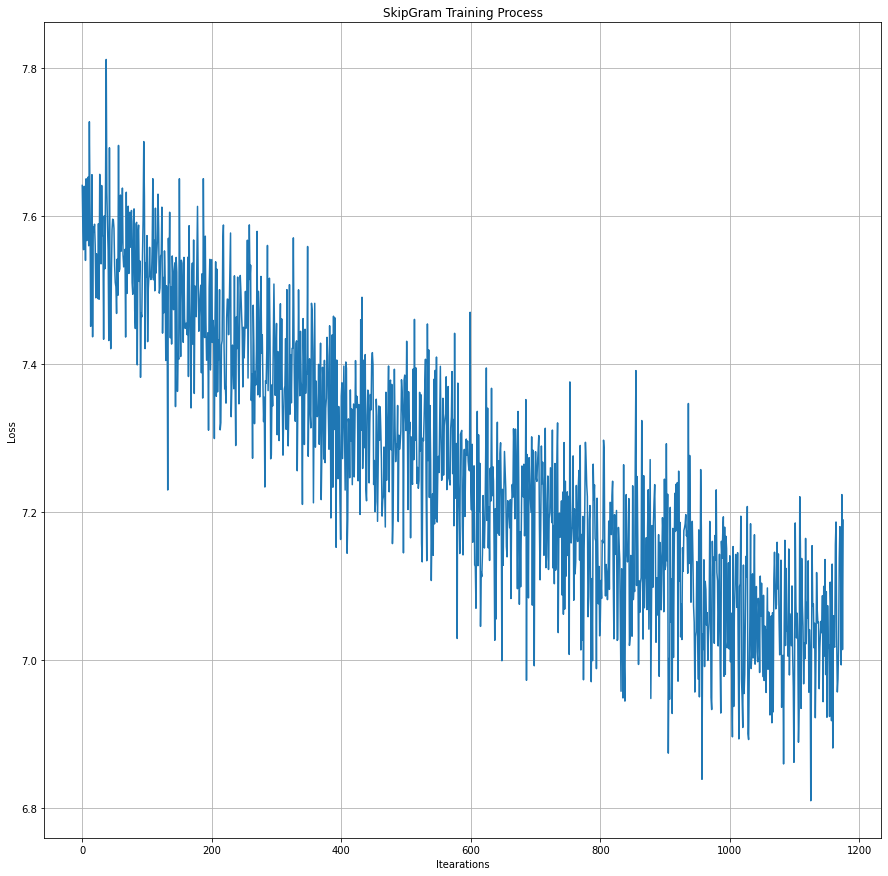

In [77]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [78]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [79]:
embedding_matrix = model.in_embedding.weight.detach()

In [80]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [81]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.11282901465892792

In [82]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

-0.14003866910934448

In [83]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.0556393563747406

In [84]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.30966269969940186

In [85]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "ответный" равна -0.018'

In [87]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [88]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [90]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 13.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 98.8883057, gradient norm = 0.0000009 (50 iterations in 9.068s)
[t-SNE] Iteration 100: error = 98.8892822, gradient norm = 0.0000000 (50 iterations in 4.304s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 98.889282
[t-SNE] Iteration 150: error = 5.7540188, gradient norm = 0.0000001 (50 iterations in 4.745s)
[t-SNE] Iteration 200: error = 4.9924121, gradient norm = 0.0008670 (50 iterations in 15.725s)
[t-SNE] Iteration 250: error = 4.8474731, gradient norm = 0.0004057 (50 iterations in 6.582s)
[t-SNE] Iteration 300: error = 4.7548218, gradient norm = 0.0002831 (50 iterations in 6.543s)
[t-SNE] Iteration 350: error = 4.6848392, gradient norm = 0.0002072 (50 iterations in 6.556s)
[t-SNE] Iteration 400: error = 4.6301260, gradient norm = 0.0001608 (50 iterations in 6.416s)
[t-SNE] Iteration 450: error = 4.5855222, gradient norm = 0.0001294 (50 iterations in 6.552s)
[t-SNE] Iteration

In [91]:
top_words = [a for a,_ in top_sorted_freq]

In [92]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

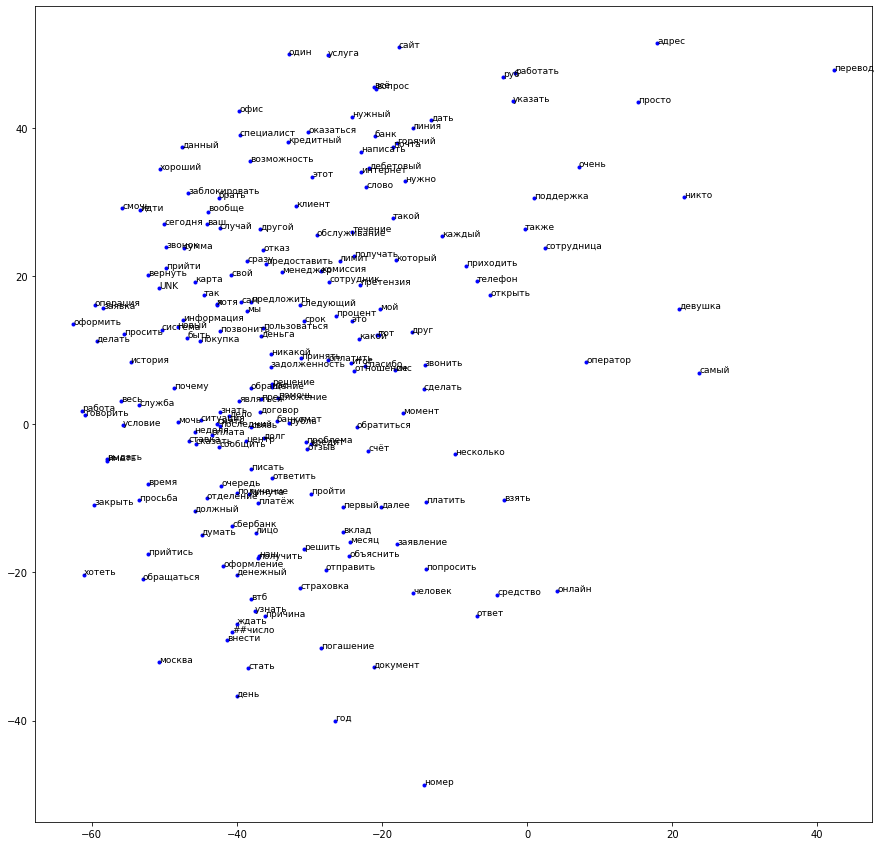

In [93]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

In [94]:
import pandas as pd

In [95]:
df_check = pd.read_csv('ru_simlex965_tagged.tsv', sep='\t')

In [96]:
df_check

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23
...,...,...,...
960,яблоко_NOUN,солнце_NOUN,0.15
961,ядро_NOUN,пушка_NOUN,2.77
962,язык_NOUN,горло_NOUN,1.38
963,ярд_NOUN,дюйм_NOUN,2.62


In [101]:
df_check_norm = df_check['Average Score'].copy()

In [103]:
df_check_norm['Average Score Norm']=(df_check_norm['Average Score']-df_check_norm['Average Score'].mean())/df_check_norm['Average Score'].std()

In [104]:
df_check_norm

,# Word1,Word2,Average Score,Average Score Norm
0,авария_NOUN,бедствие_NOUN,6.15,0.895166
1,август_NOUN,месяц_NOUN,2.85,-0.257484
2,авиация_NOUN,полет_NOUN,6.77,1.111725
3,автомобиль_NOUN,гудок_NOUN,1.85,-0.606772
4,автомобиль_NOUN,автострада_NOUN,1.23,-0.823330
...,...,...,...,...
960,яблоко_NOUN,солнце_NOUN,0.15,-1.200561
961,ядро_NOUN,пушка_NOUN,2.77,-0.285427
962,язык_NOUN,горло_NOUN,1.38,-0.770937
963,ярд_NOUN,дюйм_NOUN,2.62,-0.337820
